In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [126]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate,ChatPromptTemplate

In [ ]:
from pydantic import Field,BaseModel
from typing import List, Optional, Dict
class SelectCityInfo(BaseModel):
    city: str = Field(description="The city where the user is planning to travel")
    start_date: Optional[str] = Field(description="Start date of travel if provided, else the nearest upcoming date")
    end_date: Optional[str] = Field(description="End date of travel if provided, else the nearest upcoming date")
    from_city: Optional[str] = Field(default=None, description="City from which the user is departing (if any)")
    from_currency: Optional[str] = Field(default=None, description="Currency of the departure city/country")
    to_currency: Optional[str] = Field(default=None, description="Currency of the destination city/country")


In [242]:
from langgraph.graph import StateGraph, MessagesState,START,END
from langchain_core.output_parsers import StrOutputParser,JsonOutputParser
from langchain.tools import tool
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.runnables import RunnablePassthrough
from langchain_community.retrievers import TavilySearchAPIRetriever
tavily_retriever = TavilySearchAPIRetriever(k=3)

In [291]:
def format_docs(docs):
    return '\n\n'.join([doc.page_content for doc in docs])
def configure_llm_model():
    model = ChatGroq(model='deepseek-r1-distill-llama-70b')
    # model = ChatOpenAI(model='gpt-4o-mini')
    output = model.invoke("Hello")
    print(output)
    return model
llm = configure_llm_model()

content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 4, 'total_tokens': 20, 'completion_time': 0.088140158, 'prompt_time': 5.9758e-05, 'queue_time': 0.053686853, 'total_time': 0.088199916}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None} id='run--a6140c4c-8805-41cc-b5d6-24e3739a8962-0' usage_metadata={'input_tokens': 4, 'output_tokens': 16, 'total_tokens': 20}


In [295]:
from langchain.tools import tool  
import requests

@tool
def select_attraction(query: str) -> str:
    """
    Select four or five tourist attractions in the city specified in the query.
    
    Args:
        query (str): The user query that contains the city name.
        
    Returns:
        str: A brief summary listing the top tourist attractions in the city.
    """
    SYSTEM_PROMPT = (
        "You are an assistant who provides a short list of top tourist attractions "
        "in the city mentioned in the query.\n\nCity query: "
    )
    prompt = SYSTEM_PROMPT + query
    return llm.invoke([prompt]).content


@tool
def select_activities(query: str) -> str:
    """
    Select a few popular activities in the city specified in the query.
    
    Args:
        query (str): The user query that contains the city name.
        
    Returns:
        str: A brief summary of popular activities in the city.
    """
    SYSTEM_PROMPT = (
        "You are an assistant who provides a short list of the best tourist activities "
        "in the city mentioned in the query.\n\nCity query: "
    )
    prompt = SYSTEM_PROMPT + query
    return llm.invoke([prompt]).content


@tool
def select_restaurants(query: str) -> str:
    """
    Suggest a few of the best restaurants in the specified city.
    
    Args:
        query (str): The user query that contains the city name.
        
    Returns:
        str: A brief summary of top-rated restaurants in the city.
    """
    SYSTEM_PROMPT = (
        "You are an assistant who provides a short list of top restaurants "
        "in the city mentioned in the query.\n\nCity query: "
    )
    prompt = SYSTEM_PROMPT + query
    return llm.invoke([prompt]).content


@tool
def search_transportation(query: str) -> str:
    """
    Suggest the best transportation options in the specified city.
    
    Args:
        query (str): The user query that contains the city name.
        
    Returns:
        str: A summary of transportation options in the city.
    """
    SYSTEM_PROMPT = (
        "You are an assistant who provides a short list of transportation options "
        "in the city mentioned in the query.\n\nCity query: "
    )
    prompt = SYSTEM_PROMPT + query
    return llm.invoke([prompt]).content

@tool
def extract_cityinfo(query:str):
    """This function helps extract the city name, Travel Start date and End date from the given user query
    
    args :
        query (string) : User query may or may not contain city and dates of travel
    Returns:
        string : With extracted city name, travel start date and end date (if available)

    """
    template = """You are a helpful classifier who extract the City,Start_Date and End_Date from the given user query and returns the output in a JSON format
    user query= {query} {format_instructions}"""
    parser = JsonOutputParser(pydantic_object=SelectCityInfo)
    prompt = PromptTemplate(template=template,
                            input_variables=['query'],
                            partial_variables={'format_instructions':parser.get_format_instructions()})
    llm_chain = prompt | llm | parser
    citydetails = llm_chain.invoke(query)
    city = citydetails.get('city')
    start_date = citydetails.get('start_date',None)
    end_date = citydetails.get('end_date',None)
    return f"city : {city}, travel start date : {start_date}, travel end date : {end_date}"

@tool
def extract_currentweather(city:str):
    """This function helps extract the current weather situation in the given city.
    
    args :
        city (string) : City name where the user is planning to travel.
    Returns:
        string : A short description of current weather situation including the temperature, hudmidity and wind etc.

    """
    query = f"help me get the current weather condition in {city}" 

    template = """Answer the question based only on the context provided.
        Context: {context}

        Question: {query}"""
    prompt = PromptTemplate(template=template,
                            input_variables=['query','context'])
    chain = (
            {"context": tavily_retriever | format_docs, "query": RunnablePassthrough()}
            | prompt
            | llm
            | StrOutputParser()
            )

    response = chain.invoke(query)
    return {'messages':[response]}

@tool
def weather_forecast(city:str):
    """This function helps search for the weather forecast in the given city.
    
    args :
        city (string) : City name where the user is planning to travel.
    Returns:
        string : A short description of weather forecast in next few days.

    """
    query = f"help me get the weather forecast in {city} for next few days" 

    template = """Answer the question based only on the context provided.
        Context: {context}

        Question: {query}"""
    prompt = PromptTemplate(template=template,
                            input_variables=['query','context'])
    chain = (
            {"context": tavily_retriever | format_docs, "query": RunnablePassthrough()}
            | prompt
            | llm
            | StrOutputParser()
            )

    response = chain.invoke(query)
    return {'messages':[response]}

@tool
def search_hotels(city:str):
    """This function helps search for the hotels in the given city.
    
    args :
        city (string) : City name where the user is planning to travel.
    Returns:
        string : A detailed list of hotels for accomdations within the city.

    """
    query = f"help me search for best hotels in {city} for next few days" 

    template = """Answer the question based only on the context provided. Also show the hotel details(name and location) based on different budget options. 
        Context: {context}. 

        Question: {query}"""
    prompt = PromptTemplate(template=template,
                            input_variables=['query','context'])
    chain = (
            {"context": tavily_retriever | format_docs, "query": RunnablePassthrough()}
            | prompt
            | llm
            | StrOutputParser()
            )

    response = chain.invoke(query)
    return {'messages':[response]}

@tool
def estimate_hotel_cost(number_of_days:int,per_day_amount:float)->float:
    """This function calculates the estimated total cost.
    
    args:
        number_of_days (int) : The number of days the person going to stay in the hotel
        per_day_amount (float) : The amount that will be charged by the hotel per day
    Returns:
        total_cost : returns the estimated total hotel cost """
    
    return number_of_days*per_day_amount



In [272]:
tools = [select_attraction,select_activities,select_restaurants,
         search_transportation,extract_cityinfo,extract_currentweather,
         weather_forecast,search_hotels,estimate_hotel_cost,
         get_exchange_rate,convert_currency]
llm_with_tools = llm.bind_tools(tools)

In [296]:
def llm_descision_step(state:MessagesState):
    query = state['messages']
    SYSTEM_PROMPT = """
    You are a smart travel assistant that helps users plan trips using various tools like 
    select_attraction, select_activities , select best restaurants, select best transportation facilities,
    extract weather situation, forecast weather, search for hotels and estimate_hotel_cost, get exchange rates, convert currency to local currency etc.

    Your goals:
        - Recommend major tourist attractions, and activities.
        - Tailor suggestions to the user's preferences, location, and context.
        - Use tools when appropriate to get accurate or live data (e.g. flights, weather, maps).
        - Also do computations to estimate the total cost of hotel stay.
        - Be concise, informative, and friendly.

    Output should be actionable and well-structured. Include specific names of places, activities, and reasons they are worth visiting."""
    prompt = [SYSTEM_PROMPT] + query

    response = llm_with_tools.invoke(prompt)
    return {'messages':[response]}



In [297]:
Tool_Node = ToolNode(tools)

In [298]:
#print(select_attraction("Help me with travel plan to Singapore!"))

In [299]:
#llm_descision_step({'messages':["Help me with travel plan to Singapore!"]})

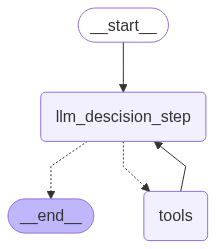

In [300]:
workflow = StateGraph(MessagesState)
workflow.add_node('llm_descision_step',llm_descision_step)
workflow.add_node('tools',Tool_Node)
workflow.add_edge(START,"llm_descision_step")
workflow.add_conditional_edges('llm_descision_step',
                               tools_condition)
workflow.add_edge('tools','llm_descision_step')
app = workflow.compile()
app

In [301]:
# state = {'messages':["Help me with travel plan to Singapore!"]}
# for output in app.stream(state):
#     for key,values in output.items():
#         print(values['messages'][-1].pretty_print())

In [302]:
state = {'messages':["Help me create a comprehensive travel plan from Palakkad to Paris"]}
response = app.invoke(state)
print(response['messages'][-1].content)

Here's a comprehensive travel plan for your trip from Palakkad to Paris:

### 1. **Top Tourist Attractions in Paris**
- **Eiffel Tower**: An iconic engineering marvel offering breathtaking views of Paris, especially stunning at sunset or when illuminated at night.
- **Louvre Museum**: The world’s largest art museum, home to masterpieces such as the Mona Lisa. A must-see for art lovers!
- **Notre-Dame Cathedral**: A historic Gothic cathedral, still a significant symbol of Paris despite ongoing restorations.
- **Arc de Triomphe**: An impressive monument honoring French military history, providing panoramic views from the rooftop.
- **Sacré-Cœur Basilica in Montmartre**: A stunning white church located in the artistic Montmartre district, known for its vibrant culture and history.

### 2. **Recommended Activities**
- **Eiffel Tower Visit**: Ascend to the top for panoramic views or enjoy a meal at one of its restaurants.
- **Louvre Museum Tour**: Explore the extensive art collections with 

In [303]:
for i in response['messages']:
    print(i.pretty_print())

================================ Human Message =================================

Help me create a comprehensive travel plan from Palakkad to Paris
None
================================== Ai Message ==================================
Tool Calls:
  extract_cityinfo (call_1NuRESoLebZJ7C40AQ6fAhAe)
 Call ID: call_1NuRESoLebZJ7C40AQ6fAhAe
  Args:
    query: Travel plan from Palakkad to Paris
None
================================= Tool Message =================================
Name: extract_cityinfo

city : Paris, travel start date : None, travel end date : None
None
================================== Ai Message ==================================
Tool Calls:
  select_attraction (call_pYGLlXjwAEFTAi0YwTbEPBRl)
 Call ID: call_pYGLlXjwAEFTAi0YwTbEPBRl
  Args:
    query: Paris
  select_activities (call_4eGqiL8snmmaD4eefrxhjFZw)
 Call ID: call_4eGqiL8snmmaD4eefrxhjFZw
  Args:
    query: Paris
  select_restaurants (call_fxjtbhEVr8SmUmq1bxhFt7WB)
 Call ID: call_fxjtbhEVr8SmUmq1bxhFt7WB
  Args:
   